In [7]:
import numpy as np
import os
import pydicom as dicom
from tqdm import tqdm
from skimage.transform import resize
import matplotlib.pyplot as plt
import pandas as pd
import cv2

def sample_patient_volume(folder, depth_downsample_rate = None, lw_downsample_rate = None):
    """
    Standardize the pixel array from DICOM metadata.
    """
    
    filenames = sorted([int(filename.split('.')[0]) for filename in os.listdir(folder)])
    filenames = [str(filename) + '.dcm' for filename in filenames]
    start_index = int(len(filenames) * 0.05)
    end_index = int(len(filenames) * 0.95)
    
    filenames = filenames[start_index:end_index]
    
    if depth_downsample_rate:
        filenames = filenames[::depth_downsample_rate]

    volume = []
    for filename in filenames:
        filepath = os.path.join(folder, filename)
        dcm = dicom.dcmread(filepath)
        
        pixel_array = dcm.pixel_array
        if dcm.PixelRepresentation == 1:
            bit_shift = dcm.BitsAllocated - dcm.BitsStored
            dtype = pixel_array.dtype 
            pixel_array = (pixel_array << bit_shift).astype(dtype) >> bit_shift

        intercept = float(dcm.RescaleIntercept)
        slope = float(dcm.RescaleSlope)
        center = int(dcm.WindowCenter)
        width = int(dcm.WindowWidth)
        low = center - width / 2
        high = center + width / 2

        pixel_array = (pixel_array * slope) + intercept
        pixel_array = np.clip(pixel_array, low, high)

        pixel_array -= np.min(pixel_array)

        pixel_array = (pixel_array / np.max(pixel_array) * 255).astype(np.int16)
        
        if lw_downsample_rate:
            pixel_array = pixel_array[::lw_downsample_rate, ::lw_downsample_rate]
        
        volume.append(pixel_array)
        
    volume = np.array(volume)
    
    return volume

In [2]:
# Get the current working directory
current_directory = os.getcwd()

# Construct the path to the train_images directory located one level up
train_base_directory = os.path.join(current_directory, 'train_images')


In [3]:
# Collect all the DICOM file paths along with patient IDs and series IDs
dicom_data = []
for patient_id in tqdm(os.listdir(train_base_directory), desc="Processing Patients"):
    patient_dir = os.path.join(train_base_directory, patient_id)
    for series_id in os.listdir(patient_dir):
        series_dir = os.path.join(patient_dir, series_id)
        dicom_data.append({'series_dir': series_dir, 'patient_id': patient_id, 'series_id': series_id})

# Create a DataFrame using the collected data
dicom_df = pd.DataFrame(dicom_data)


Processing Patients: 100%|██████████| 3147/3147 [00:00<00:00, 55844.79it/s]


In [38]:
import numpy as np
import os
import pydicom as dicom
from tqdm import tqdm
from skimage.transform import resize
import matplotlib.pyplot as plt
import pandas as pd

# Define a function to get bounding box of the largest contour in an image
def get_bounding_box(image):
    # Normalize the image to the range [0, 255]
    normalized_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Now, apply Otsu's thresholding
    _, binary_image = cv2.threshold(normalized_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Noise reduction using morphological opening
    kernel = np.ones((5,5), np.uint8)
    opened_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)
    opened_image = cv2.morphologyEx(opened_image, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(opened_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assuming the largest contour corresponds to the abdominal region, find its bounding box
    if contours:
        # Sort contours by area and take the largest one
        largest_contour = max(contours, key=cv2.contourArea)

        # Get bounding box of the largest contour
        x, y, w, h = cv2.boundingRect(largest_contour)

    else:
        x, y, w, h = 0, 0, 0, 0  # Default values in case no contours are found

    # The bounding box is represented by the top-left corner (x, y) and the width and height (w, h)
    bounding_box = (x, y, w, h)
    
    return bounding_box
    
def determine_bbox(folder, depth_downsample_rate = None, lw_downsample_rate = None):
    """
    Standardize the pixel array from DICOM metadata.
    """
    
    filenames = sorted([int(filename.split('.')[0]) for filename in os.listdir(folder)])
    filenames = [str(filename) + '.dcm' for filename in filenames]
#     start_index = int(len(filenames) * 0.05)
#     end_index = int(len(filenames) * 0.95)
    
#     filenames = filenames[start_index:end_index]
    
    if depth_downsample_rate:
        filenames = filenames[::depth_downsample_rate]

    bbox_list = []
    for filename in filenames:
        filepath = os.path.join(folder, filename)
        dcm = dicom.dcmread(filepath)
        
        pixel_array = dcm.pixel_array
        if dcm.PixelRepresentation == 1:
            bit_shift = dcm.BitsAllocated - dcm.BitsStored
            dtype = pixel_array.dtype 
            pixel_array = (pixel_array << bit_shift).astype(dtype) >> bit_shift

        intercept = float(dcm.RescaleIntercept)
        slope = float(dcm.RescaleSlope)
        center = int(dcm.WindowCenter)
        width = int(dcm.WindowWidth)
        low = center - width / 2
        high = center + width / 2

        pixel_array = (pixel_array * slope) + intercept
        pixel_array = np.clip(pixel_array, low, high)

        pixel_array -= np.min(pixel_array)

        pixel_array = (pixel_array / np.max(pixel_array) * 255).astype(np.int16)
        
        bbox = get_bounding_box(pixel_array)
        
        bbox_list.append(bbox)
        
    bbox_list = np.array(bbox_list)
    
    areas = bbox_list[:, 2] * bbox_list[:, 3]  # width * height for each bbox

    # Get the index of the maximum area
    max_area_index = np.argmax(areas)
    
    min_area_index = np.argmin(areas)
    
    return bbox_list, max_area_index, min_area_index

In [39]:
# Create an empty list to collect bounding box data
bbox_data = []

current_todo = len(dicom_df)

series_dir_list = np.array(dicom_df['series_dir'])
for i in tqdm(range(current_todo), desc="Processing Patients"):
    bbox_list, max_area_index, min_area_index = determine_bbox(series_dir_list[i], depth_downsample_rate = 4)
    
    # Store the bounding box data with the series_id
    bbox_data.append({
        "series_id": series_dir_list[i],
        "max_area_index": max_area_index,
        "min_area_index": min_area_index,
        "bbox_x": bbox_list
    })
# Convert the list to a pandas DataFrame
df = pd.DataFrame(bbox_data)

# Save the DataFrame to a CSV file
df.to_csv('bbox_data.csv', index=False)


Processing Patients: 100%|██████████| 4711/4711 [58:38<00:00,  1.34it/s]  


In [40]:
df

,series_id,max_area_index,min_area_index,bbox_x
0,/workspace/0728tot/ATD/train_images/38867/9877,3,67,"[[0, 117, 504, 290], [0, 114, 501, 293], [0, 1..."
1,/workspace/0728tot/ATD/train_images/6579/36113,5,15,"[[86, 68, 426, 320], [85, 58, 427, 329], [84, ..."
2,/workspace/0728tot/ATD/train_images/6579/59108,0,21,"[[5, 71, 507, 318], [71, 69, 441, 320], [87, 6..."
3,/workspace/0728tot/ATD/train_images/16727/54772,8,29,"[[0, 123, 471, 297], [0, 122, 468, 296], [0, 1..."
4,/workspace/0728tot/ATD/train_images/32613/31599,0,88,"[[0, 70, 446, 318], [0, 68, 443, 318], [4, 67,..."
...,...,...,...,...
4706,/workspace/0728tot/ATD/train_images/648/30074,0,29,"[[27, 107, 425, 283], [38, 103, 406, 289], [44..."
4707,/workspace/0728tot/ATD/train_images/16859/38307,1,40,"[[109, 153, 356, 257], [66, 152, 396, 258], [1..."
4708,/workspace/0728tot/ATD/train_images/8389/46753,119,151,"[[125, 208, 381, 176], [124, 208, 248, 171], [..."
4709,/workspace/0728tot/ATD/train_images/18001/52455,7,74,"[[63, 214, 420, 182], [53, 214, 441, 187], [45..."


In [34]:
bounding_box = df['bbox_x'][0][-20]

In [30]:
bounding_box = df['bbox_x'][0][df['max_area_index'][0]]

In [15]:
volume_0 = sample_patient_volume(df['series_id'][0], depth_downsample_rate = 4, lw_downsample_rate = None)

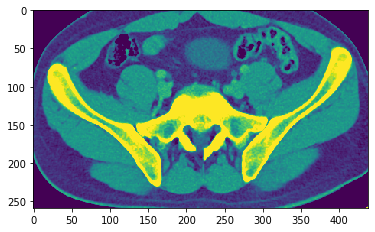

In [35]:
# Load the image
image = volume_0[-20]

plt.imshow(image[bounding_box[1]:bounding_box[1]+bounding_box[3],
                bounding_box[0]:bounding_box[0]+bounding_box[2]])